In [1]:
import argparse
import os, sys, json, math
import shutil
import time, copy
from tqdm import tqdm

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

import numpy as np

import torchvision
from torchvision import datasets, models, transforms, utils
from inceptionresnetv2.pytorch_load import inceptionresnetv2
from inceptionv4.pytorch_load import inceptionv4
from PIL import Image
import cPickle as pkl

import warnings
warnings.filterwarnings("ignore")

from dataset import Dataset

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) 

class NLayerDiscriminatorMod(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, max_mult=8, norm_layer=nn.BatchNorm2d, feat_len=256):
        super(NLayerDiscriminatorMod, self).__init__()
        use_bias = False
        kw = 3

        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=7, stride=2, padding=3),
            norm_layer(ndf),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, max_mult)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult)]
            sequence += [nn.LeakyReLU(0.2, True)]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, max_mult)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=3, stride=1, padding=padw)]
        # sequence += [nn.AvgPool2d(7, stride=1)]
        # sequence += [nn.Linear(feat_len, 1)]
        sequence += [Flatten(), nn.Linear(feat_len, 1)]

        sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


In [3]:
model = NLayerDiscriminatorMod(3, ndf=16, n_layers = 6, max_mult=8, feat_len=4)
model = model.cuda()
checkpoint = torch.load('../../../checkpoints/fake_detect_models/dis_mod_v3_3_balanced_cont/chkpt_2100.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

NLayerDiscriminatorMod(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padd

In [64]:
def load_dis(path):
    dis_model = NLayerDiscriminatorMod(3, ndf=16, n_layers = 6, max_mult=8, feat_len=4)
    dis_model = dis_model.cuda()
    checkpoint = torch.load(path)
    dis_model.load_state_dict(checkpoint['state_dict'])
    dis_model.eval()
    return dis_model

#### v1
# dis_model_0_b = load_dis('./dis_mod_v2_0_balanced/chkpt_7700.pth.tar')
# dis_model_1_b = load_dis('./dis_mod_v2_1_balanced/chkpt_10700.pth.tar')
# dis_model_2_b = load_dis('./dis_mod_v2_2_balanced/chkpt_7000.pth.tar')
# dis_model_3_b = load_dis('./dis_mod_v2_3_balanced/chkpt_6700.pth.tar')
# dis_model_all_b = load_dis('./dis_mod_v2_all_balanced/chkpt_2300.pth.tar')
dis_model_0_b = load_dis('./dis_mod_v2_0_balanced/chkpt_7700.pth.tar')
dis_model_1_b = load_dis('./dis_mod_v2_1_balanced/chkpt_10700.pth.tar')
dis_model_2_b = load_dis('./dis_mod_v2_2_balanced/chkpt_7000.pth.tar')
dis_model_3_b = load_dis('./dis_mod_v2_3_balanced/chkpt_6700.pth.tar')
dis_model_all_b = load_dis('./dis_mod_v2_all_balanced/chkpt_2300.pth.tar')
dis_model_0_n = load_dis('./dis_mod_v2_0_normal/chkpt_4800.pth.tar')
dis_model_1_n = load_dis('./dis_mod_v2_1_normal/chkpt_6500.pth.tar')
dis_model_2_n = load_dis('./dis_mod_v2_2_normal/chkpt_5600.pth.tar')
dis_model_3_n = load_dis('./dis_mod_v2_3_normal/chkpt_4800.pth.tar')

dis_model_all_b_v2 = load_dis('./dis_mod_v3_all_balanced/chkpt_2100.pth.tar')

In [4]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                      std=[0.5, 0.5, 0.5])
trans = transforms.Compose([
    transforms.Scale(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    normalize
])

In [25]:
import glob
for i in range(0,4):
    exec('input_imgs_path_%d = glob.glob("./dataset/fake_v2/%d/bad_val/*")'%(i,i))
    exec('input_imgs_path_%d += glob.glob("./dataset/fake_v2/%d/good_val/*")'%(i,i))
# input_imgs_path += glob.glob('../labled/good/*')

In [13]:
len(input_imgs_path)

7857

0.97	1.00	0.99	0.01	0.03	1.00	
0.99	0.03	0.89	0.83	1.00	0.29	
0.72	0.96	0.00	0.16	0.25	0.27	
0.96	0.97	0.01	1.00	0.00	0.94	
0.94	0.99	0.96	0.21	0.14	1.00	
0.98	0.26	0.89	0.93	1.00	0.18	
0.74	0.84	0.02	0.30	0.25	0.16	
0.99	0.99	0.04	0.98	0.01	0.96	


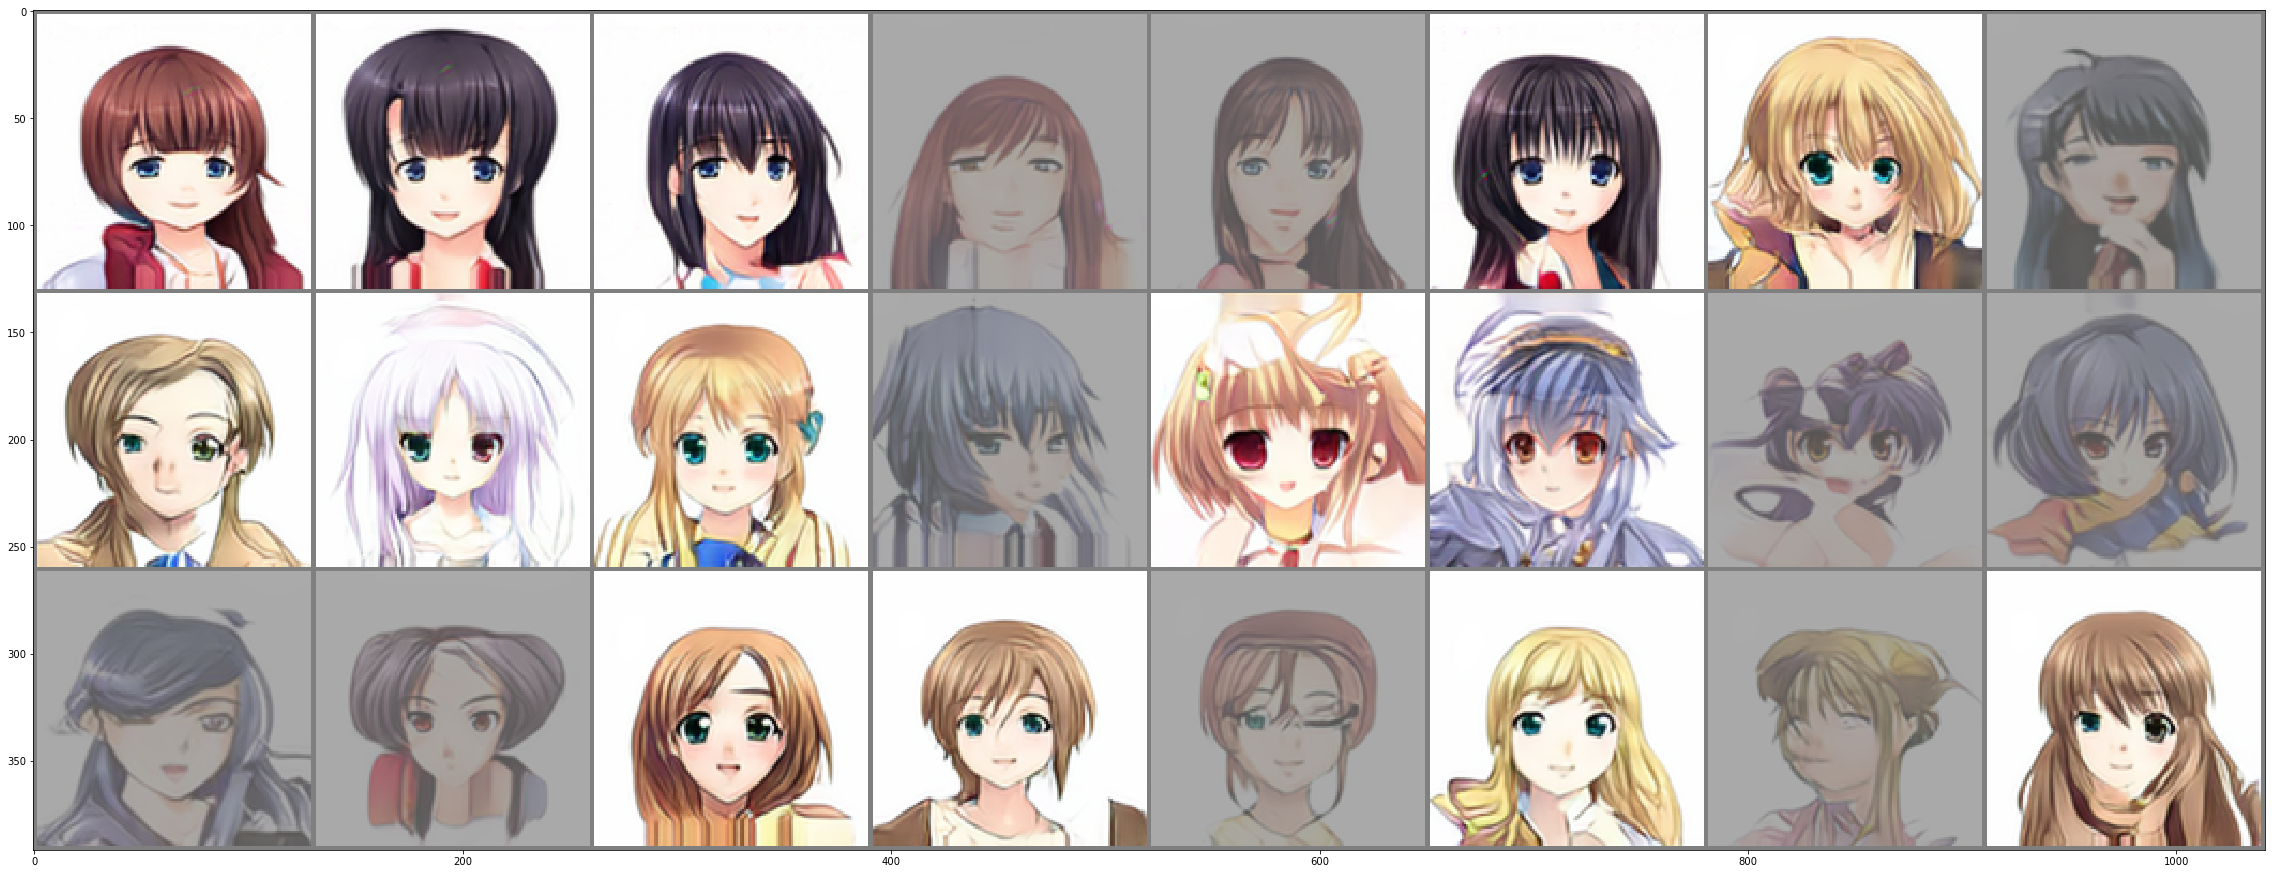

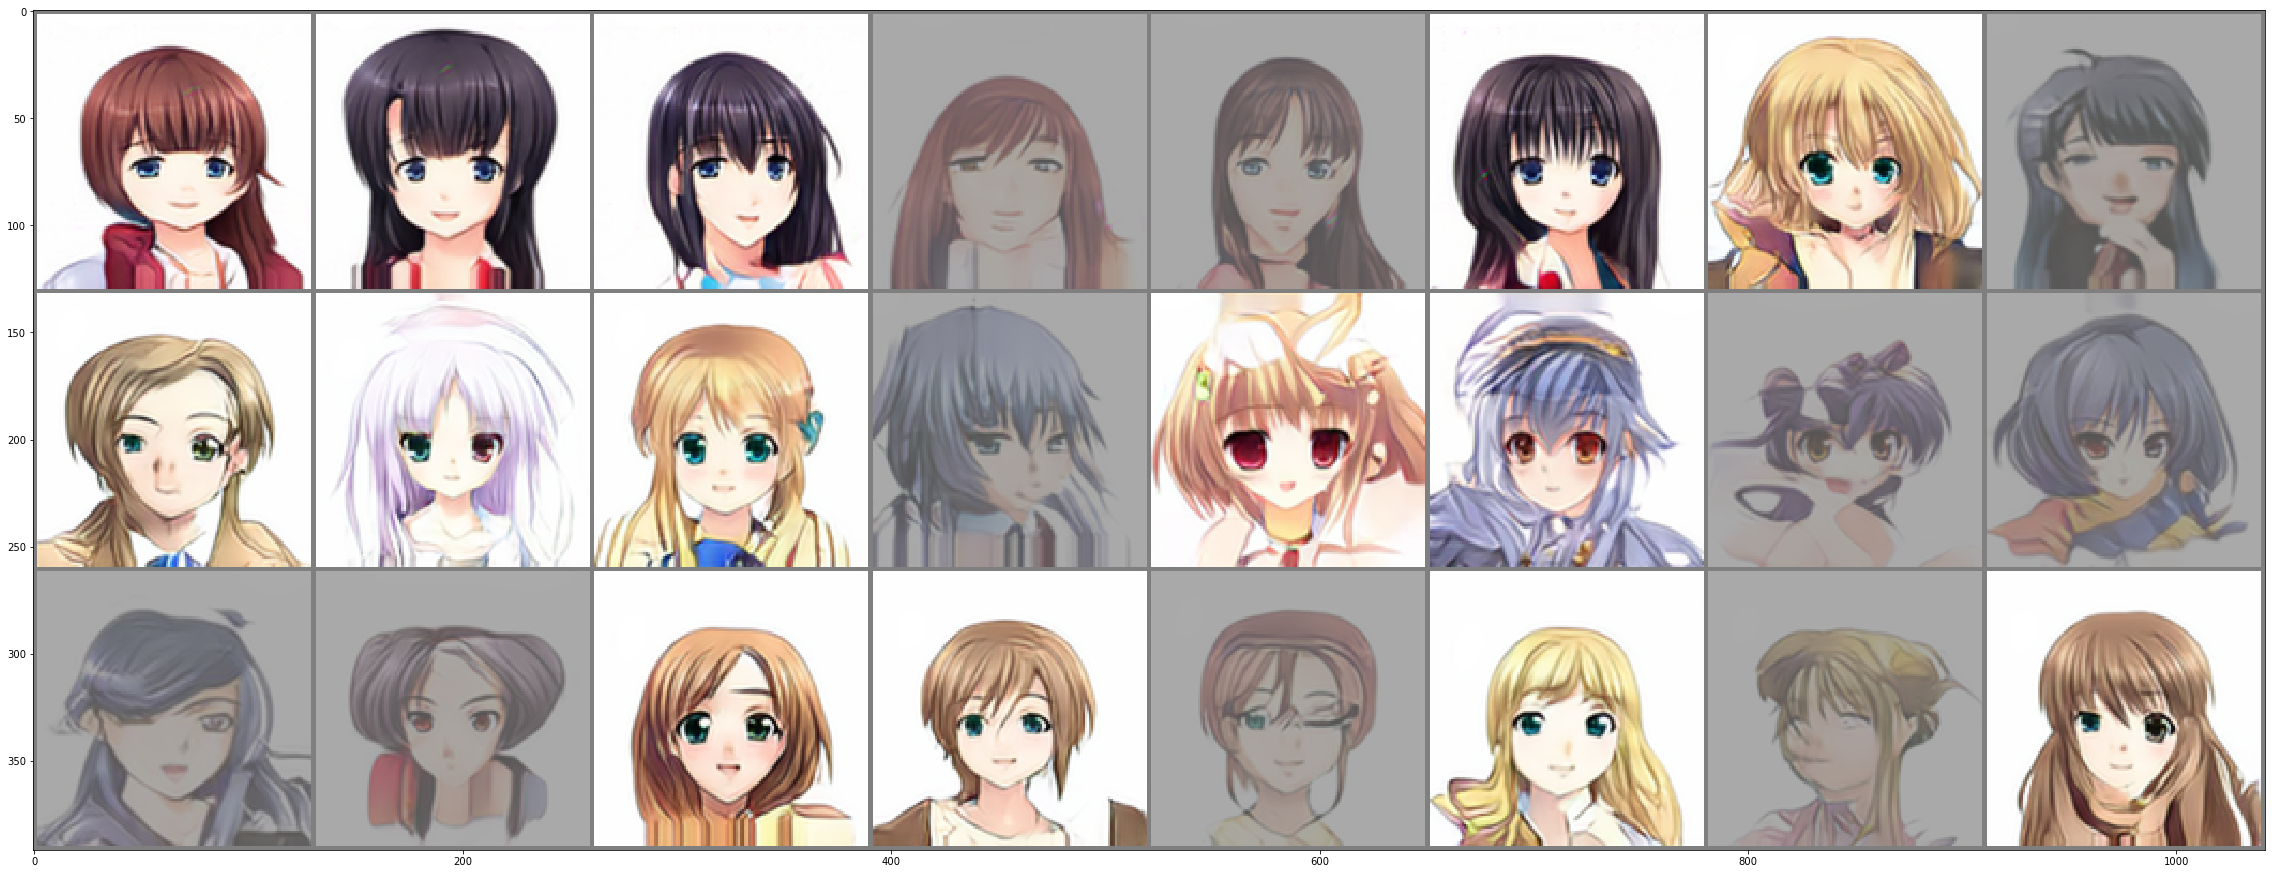

In [85]:
%matplotlib inline
import random
import glob
import os
from PIL import Image
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

def show(img, show=True):
    npimg = img.numpy()
    npimg = ((npimg / 2.0) + 0.5) * 255.0
    npimg = npimg.astype(np.uint8)
    if show:
        plt.figure(figsize = (40,40))
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    return Image.fromarray(npimg.transpose((1,2,0)))

# m = net_12['B']
def set_eval(net, bn=False, drop=True):
    if isinstance(net, torch.nn.Dropout):
        net.training = not drop
    elif  isinstance(net, torch.nn.BatchNorm2d) or  isinstance(net, torch.nn.InstanceNorm2d):
        net.training = not bn
    else:
        net.training = False
    for i in net.children():
        set_eval(i, bn, drop)

show_img = []
show_score = []
show_img_all = []
show_score_all = []
count = 0
for i in range(24):
    curr_idx = int(i / 6) 
    dis_model_all_b.eval()
    img_path = random.choice(eval('input_imgs_path_%d'%curr_idx))
    img = Image.open(img_path)
    img_t = trans(img)
    input_var = torch.autograd.Variable(img_t, volatile=True).cuda()
    input_var = input_var.view(1,3,128,128)
    output = eval('dis_model_all_b(input_var)')
    if output.data.cpu().numpy() < 0.5:
        show_img.append(img_t / 3)
    else:
        show_img.append(img_t)
    show_score.append(output.data[0])
    
    output = eval('dis_model_all_b_v2(input_var)')
    if output.data.cpu().numpy() < 0.5:
        show_img_all.append(img_t / 3)
    else:
        show_img_all.append(img_t)
    show_score_all.append(output.data[0])

_ = show(torchvision.utils.make_grid(show_img,nrow=8))
_ = show(torchvision.utils.make_grid(show_img_all,nrow=8))
for idx, i in enumerate(show_score):
    print '%.2f\t'%i.cpu().numpy()[0],
    if (idx+1) % 6 == 0:
        print ''

print '==========='

for idx, i in enumerate(show_score_all):
    print '%.2f\t'%i.cpu().numpy()[0],
    if (idx+1) % 6 == 0:
        print ''

In [121]:
%matplotlib inline
import random
import glob
import os
from PIL import Image
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

def show(img, show=True):
    npimg = img.numpy()
    npimg = ((npimg / 2.0) + 0.5) * 255.0
    npimg = npimg.astype(np.uint8)
    if show:
        plt.figure(figsize = (40,40))
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    return Image.fromarray(npimg.transpose((1,2,0)))

show_img = []
show_score = []
count = 0
# for i in range(len(input_imgs_path)):
for img_path in tqdm.tqdm_notebook(input_imgs_path):
#     img_path = random.choice(input_imgs_path)
    img = Image.open(img_path)
    img_t = trans(img)
    input_var = torch.autograd.Variable(img_t, volatile=True).cuda()
    input_var = input_var.view(1,3,128,128)
    output = model(input_var)
    if output.data.cpu().numpy() < 0.3:
        count += 1

count

613

In [52]:
random.choice(input_imgs_path_2)

'./dataset/fake_v2/2/good_val/2_21532.png'